In [1]:
import pandas as pd
import numpy as np

In [3]:
combined_df = pd.read_csv(r"Combined_data.csv")

# Check data dimensions
print(f"\nCombined dataset shape: {combined_df.shape}")


Combined dataset shape: (99514, 40)


In [4]:
label_col = "Label"

In [5]:
# Display class distribution
print("\nClass distribution (attack types):")
label_counts = combined_df[label_col].value_counts()
label_percentages = combined_df[label_col].value_counts(normalize=True) * 100

# Create a dataframe to show counts and percentages side by side
distribution_df = pd.DataFrame({
    'Count': label_counts,
    'Percentage': label_percentages
})
print(distribution_df)


Class distribution (attack types):
                         Count  Percentage
Label                                     
DDoS-ICMP_Flood           3000    3.014651
XSS                       3000    3.014651
Backdoor_Malware          3000    3.014651
VulnerabilityScan         3000    3.014651
DoS-UDP_Flood             3000    3.014651
SqlInjection              3000    3.014651
Recon-PortScan            3000    3.014651
DDoS-SlowLoris            3000    3.014651
DDoS-UDP_Flood            3000    3.014651
DNS_Spoofing              3000    3.014651
Mirai-udpplain            3000    3.014651
DoS-HTTP_Flood            3000    3.014651
MITM-ArpSpoofing          3000    3.014651
DDoS-UDP_Fragmentation    3000    3.014651
Mirai-greip_flood         3000    3.014651
DDoS-ICMP_Fragmentation   3000    3.014651
Mirai-greeth_flood        3000    3.014651
DDoS-RSTFINFlood          3000    3.014651
DictionaryBruteForce      3000    3.014651
DDoS-SynonymousIP_Flood   3000    3.014651
Recon-HostDiscover

In [6]:
#Save original dataset for reference
original_df = combined_df.copy()

In [7]:
#Display feature information
print(f"\nTotal number of features: {len(combined_df.columns) - 1}")  # Exclude Label


Total number of features: 39


In [8]:
#Check for missing values in the dataset
missing_values = combined_df.isnull().sum()
print(missing_values[missing_values > 0])

#Check for infinite values
inf_counts = np.isinf(combined_df.select_dtypes(include=[np.number])).sum()
print(inf_counts[inf_counts > 0])

#Check feature types
print(combined_df.dtypes.value_counts())

Std         3
Variance    3
dtype: int64
Rate    3
dtype: int64
float64    30
int64       9
object      1
Name: count, dtype: int64


In [9]:
#Identify numeric and categorical features
numeric_features = combined_df.select_dtypes(include=[np.number]).columns.tolist()
if label_col in numeric_features:
    numeric_features.remove(label_col)
    
categorical_features = combined_df.select_dtypes(include=['object']).columns.tolist()
if label_col in categorical_features:
    categorical_features.remove(label_col)

print(f"\nNumeric features: {len(numeric_features)}")
print(f"Categorical features: {len(categorical_features)}")


Numeric features: 39
Categorical features: 0


## Data Splitting

In [10]:
from sklearn.model_selection import train_test_split

#Split into 70% train and 30% temp (15% validation and 15% test)
train_df, temp_df = train_test_split(
    combined_df,
    test_size=0.30,
    stratify=combined_df[label_col],
    random_state=42
)

#Split temp into equal 50/50 (15% val and 15% test)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df[label_col],
    random_state=42
)

#Reset indices
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

#Verify the split sizes
print(f"Training set:   {train_df.shape[0]} rows ({train_df.shape[0]/combined_df.shape[0]:.1%})")
print(f"Validation set: {val_df.shape[0]} rows ({val_df.shape[0]/combined_df.shape[0]:.1%})")
print(f"Test set:       {test_df.shape[0]} rows ({test_df.shape[0]/combined_df.shape[0]:.1%})")

Training set:   69659 rows (70.0%)
Validation set: 14927 rows (15.0%)
Test set:       14928 rows (15.0%)


In [11]:
#Verifying the class distribution, that it is maintained across splits
print("\nVerifying class distribution is maintained in all splits:")
print("\nOriginal dataset:")
print(combined_df[label_col].value_counts(normalize=True).sort_index())
print("\nTraining set:")
print(train_df[label_col].value_counts(normalize=True).sort_index())
print("\nValidation set:")
print(val_df[label_col].value_counts(normalize=True).sort_index())
print("\nTest set:")
print(test_df[label_col].value_counts(normalize=True).sort_index())


Verifying class distribution is maintained in all splits:

Original dataset:
Label
BENIGN                     0.030147
Backdoor_Malware           0.030147
BrowserHijacking           0.030147
CommandInjection           0.030147
DDoS-ACK_Fragmentation     0.030147
DDoS-HTTP_Flood-           0.030147
DDoS-ICMP_Flood            0.030147
DDoS-ICMP_Fragmentation    0.030147
DDoS-PSHACK_Flood          0.030147
DDoS-RSTFINFlood           0.030147
DDoS-SYN_Flood             0.030147
DDoS-SlowLoris             0.030147
DDoS-SynonymousIP_Flood    0.030147
DDoS-TCP_Flood             0.030147
DDoS-UDP_Flood             0.030147
DDoS-UDP_Fragmentation     0.030147
DNS_Spoofing               0.030147
DictionaryBruteForce       0.030147
DoS-HTTP_Flood             0.030147
DoS-SYN_Flood              0.030147
DoS-TCP_Flood              0.030147
DoS-UDP_Flood              0.030147
MITM-ArpSpoofing           0.030147
Mirai-greeth_flood         0.030147
Mirai-greip_flood          0.030147
Mirai-udpplain  

In [12]:
#Create a copy of original splits before any preprocessing (for reference later)
train_df_original = train_df.copy()
val_df_original = val_df.copy()
test_df_original = test_df.copy()

## EDA

In [13]:
import matplotlib.pyplot as plt
from scipy.stats import skew

#Black and white plotting style to ensure the monotone colour palette required (in line with report requirements)
plt.style.use('default') 
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['black', 'gray', 'darkgray', 'lightgray', 'dimgray'])
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.color'] = 'lightgray'

In [14]:
#Handle infinite values and NaNs
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)

#Check how many NaNs we now have
na_count = train_df.isna().sum()
print("\nColumns with NaN values")
print(na_count[na_count > 0])

#Drop rows with NaN in training set only
print(f"Training set rows before dropping NaN: {len(train_df)}")
train_df.dropna(inplace=True)
print(f"Training set rows after dropping NaN: {len(train_df)}")

#Drop duplicates in training set only
train_df_len_before = len(train_df)
train_df.drop_duplicates(inplace=True)
print(f"Removed {train_df_len_before - len(train_df)} duplicate rows from training set")


Columns with NaN values
Rate        2
Std         2
Variance    2
dtype: int64
Training set rows before dropping NaN: 69659
Training set rows after dropping NaN: 69657
Removed 697 duplicate rows from training set


In [15]:
#Convert the 'Protocol Type' column to object dtype
train_df['Protocol Type'] = train_df['Protocol Type'].astype('object')
val_df['Protocol Type'] = val_df['Protocol Type'].astype('object')
test_df_original['Protocol Type'] = test_df_original['Protocol Type'].astype('object')

#Verifying the change
print(train_df['Protocol Type'].dtypes)
print(val_df['Protocol Type'].dtypes)
print(test_df_original['Protocol Type'].dtypes)

object
object
object


In [16]:
#Identify numeric features
numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
if label_col in numeric_cols:
    numeric_cols.remove(label_col)

categorical_cols = ["Protocol Type"]
print(f"\nNumeric columns ({len(numeric_cols)}): {numeric_cols[:5]}...")
print(f"Categorical columns: {categorical_cols}")



Numeric columns (38): ['Header_Length', 'Time_To_Live', 'Rate', 'fin_flag_number', 'syn_flag_number']...
Categorical columns: ['Protocol Type']



34 numeric features with |skew| > 0.75
First 10 skewed features: ['Time_To_Live', 'Rate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count']


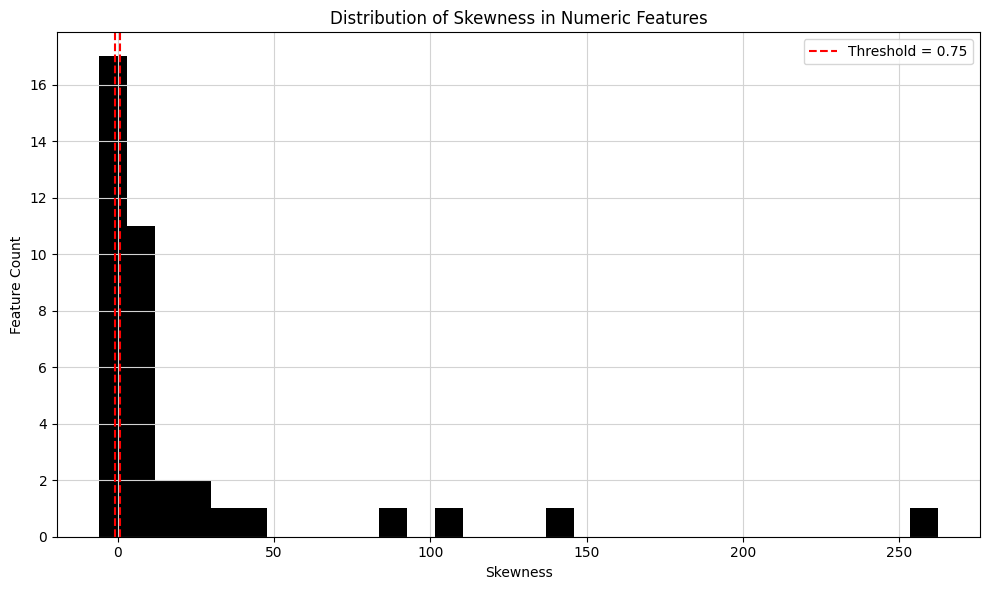

In [17]:
#Compute skewness for numeric features
skewness = train_df[numeric_cols].apply(lambda col: skew(col))

#Define a threshold to use
SKEW_THRESHOLD = 0.75

#Identify highly skewed features
skewed_feats = skewness[abs(skewness) > SKEW_THRESHOLD].index.tolist()
print(f"\n{len(skewed_feats)} numeric features with |skew| > {SKEW_THRESHOLD}")
print(f"First 10 skewed features: {skewed_feats[:10]}")

#Plot skewness distribution
plt.figure(figsize=(10, 6))
skewness.hist(bins=30)
plt.xlabel("Skewness")
plt.ylabel("Feature Count")
plt.title("Distribution of Skewness in Numeric Features")
plt.axvline(SKEW_THRESHOLD, color='r', linestyle='--', label=f'Threshold = {SKEW_THRESHOLD}')
plt.axvline(-SKEW_THRESHOLD, color='r', linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()

### Correlation matrix

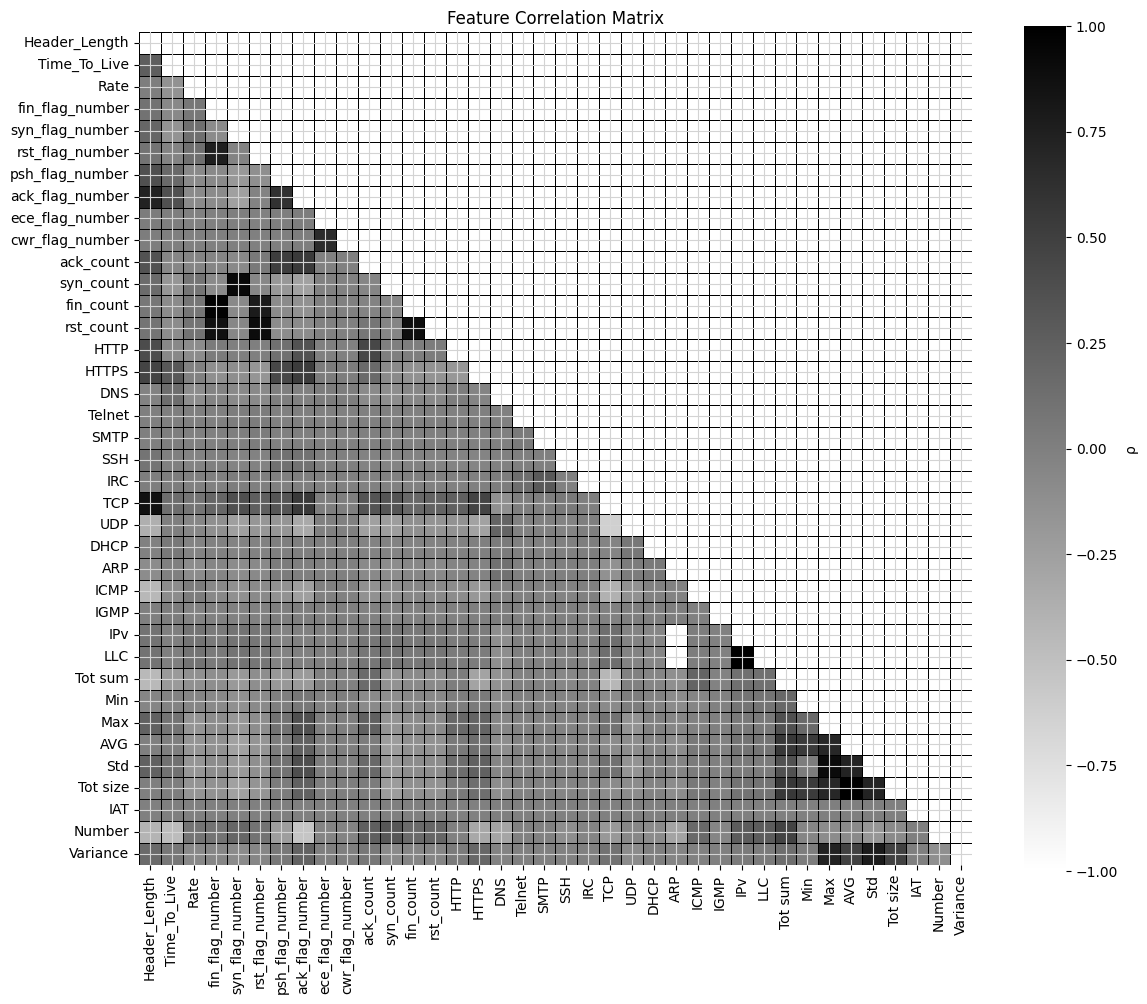

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 

plt.figure(figsize=(12, 10))

corr_matrix = train_df[numeric_cols].corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap="binary",          # ← white at –1, black at +1
    vmin=-1, vmax=1,
    square=True,
    linewidths=.5,
    linecolor="k",          # black grid lines
    cbar_kws={"label": "ρ"}
)

plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

### Top correlated feature pairs

In [19]:
corr_pairs = []
for i in range(len(numeric_cols)):
    for j in range(i+1, len(numeric_cols)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.8:  #Setting a threshold
            corr_pairs.append((numeric_cols[i], numeric_cols[j], corr_val))

#Sorting by value
corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)

print("\nTop highly correlated feature pairs:")
for feat1, feat2, corr_val in corr_pairs[:15]:
    print(f"{feat1} and {feat2}: {corr_val:.3f}")



Top highly correlated feature pairs:
ARP and IPv: -1.000
ARP and LLC: -1.000
IPv and LLC: 1.000
AVG and Tot size: 1.000
fin_flag_number and fin_count: 0.977
syn_flag_number and syn_count: 0.936
Max and Std: 0.909
rst_flag_number and rst_count: 0.903
fin_count and rst_count: 0.889
Header_Length and TCP: 0.865
fin_flag_number and rst_count: 0.860


### Outlier check in a few key features

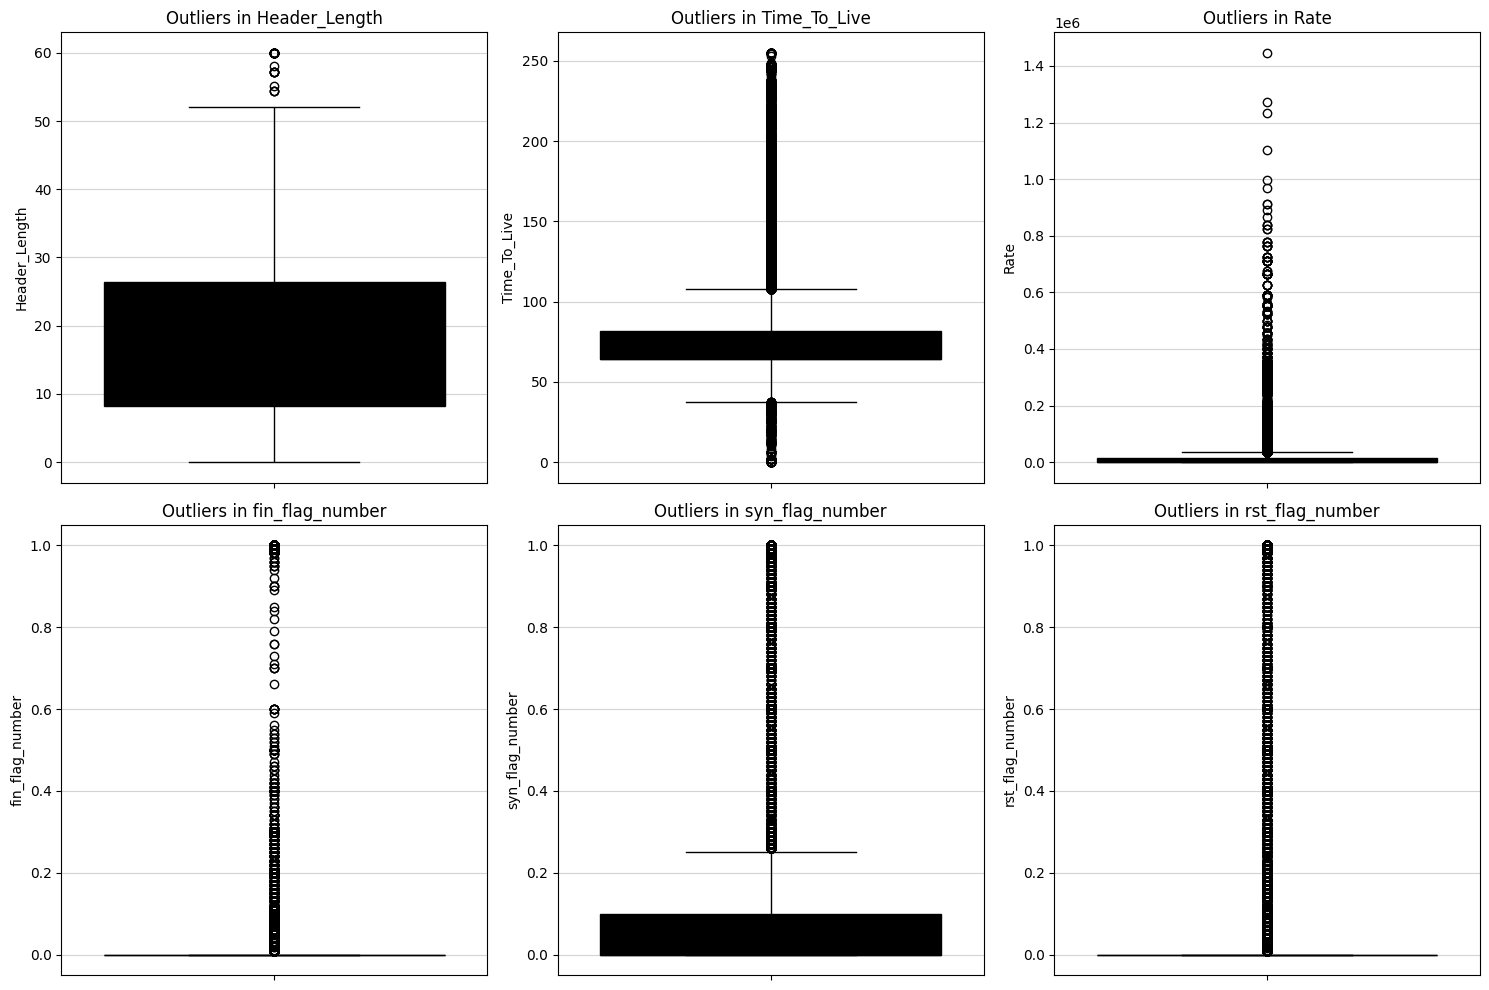

In [20]:
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numeric_cols[:6]):
    plt.subplot(2, 3, i+1)
    sns.boxplot(y=train_df[feature])
    plt.title(f"Outliers in {feature}")
    plt.tight_layout()
plt.show()

## Feature Selection

To address Feature selection, we calculate VIF for each numeric feature

In [21]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Calculate VIF for each numeric feature
#First handle any remaining NaN values for VIF calculation
X_vif = train_df[numeric_cols].fillna(0).reset_index(drop=True)

#Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = numeric_cols
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(len(numeric_cols))]

#Sort by descending VIF
vif_data = vif_data.sort_values("VIF", ascending=False).reset_index(drop=True)

print("\nTop 20 features by VIF:")
print(vif_data.head(20))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)



Top 20 features by VIF:
            feature        VIF
0               AVG        inf
1               IPv        inf
2               LLC        inf
3          Tot size        inf
4         fin_count  32.128753
5   fin_flag_number  26.613713
6               TCP  17.457097
7               Std  17.281890
8   ack_flag_number  16.843551
9   syn_flag_number  14.823855
10    Header_Length  14.172199
11        syn_count  13.150659
12        rst_count  12.130302
13           Number   9.924357
14              Max   8.232306
15  rst_flag_number   8.034357
16        ack_count   7.153168
17          Tot sum   4.985817
18              UDP   4.487036
19         Variance   3.352951


Utilizing a Random Forest classifier to get feature importance (to compare with VIF and correlation findings)

In [22]:
#Features with extremely high VIF (multicollinearity)
high_vif_features = vif_data[vif_data["VIF"] > 10]["feature"].tolist()
print(f"\nFeatures with VIF > 10 (high multicollinearity): {len(high_vif_features)}")
print(high_vif_features[:10])

X_train = train_df[numeric_cols + categorical_cols]
y_train = train_df[label_col]

#Really basic Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

#Grab the improtance information
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 features by Random Forest importance:")
print(feature_importance.head(20))


Features with VIF > 10 (high multicollinearity): 13
['AVG', 'IPv', 'LLC', 'Tot size', 'fin_count', 'fin_flag_number', 'TCP', 'Std', 'ack_flag_number', 'syn_flag_number']

Top 20 features by Random Forest importance:
            feature  importance
2              Rate    0.061491
29          Tot sum    0.060984
15            HTTPS    0.060577
34         Tot size    0.059005
32              AVG    0.058817
35              IAT    0.056399
0     Header_Length    0.053297
31              Max    0.051570
1      Time_To_Live    0.041925
37         Variance    0.041212
33              Std    0.039409
10        ack_count    0.035900
22              UDP    0.035805
11        syn_count    0.031928
38    Protocol Type    0.031526
6   psh_flag_number    0.030438
25             ICMP    0.026491
21              TCP    0.025487
7   ack_flag_number    0.024336
4   syn_flag_number    0.023752


Visualizing the low importance features


Features with very low importance (< 0.001): 6
['IRC', 'IGMP', 'ece_flag_number', 'cwr_flag_number', 'Telnet', 'SMTP']


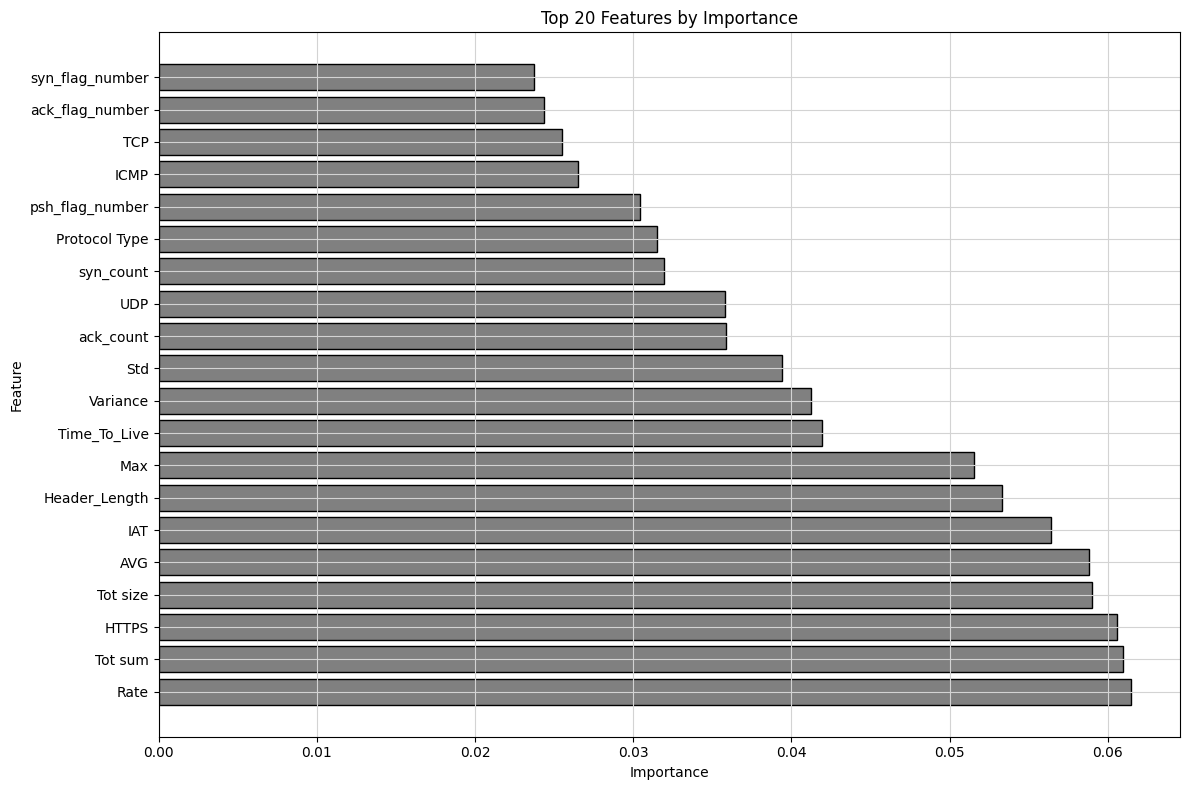

In [23]:
low_importance_features = feature_importance[feature_importance['importance'] < 0.001]['feature'].tolist()
print(f"\nFeatures with very low importance (< 0.001): {len(low_importance_features)}")
print(low_importance_features[:10])

plt.figure(figsize=(12, 8))
plt.barh(feature_importance.head(20)['feature'], feature_importance.head(20)['importance'], 
         color='gray', edgecolor='black')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Features by Importance')
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

### Outlier dropping

We applied Isolation Forest and Local Outlier Factor (LOF) to detect outliers based on the five most important features from our previous analysis. Both methods were set to identify approximately 1% of the data as outliers. Observations flagged by either model were removed, with the goal of a cleaner training set with reduced noise and potential anomalies.

In [24]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

#Select features for outlier detection - use top important features from prev analysis
outlier_features = feature_importance.head(5)['feature'].tolist()

#Extract features for outlier detection
X_outlier = train_df[outlier_features].values

#Isolation Forest for outlier detection
contamination = 0.01  #Targetting 1% outliers
iso_forest = IsolationForest(contamination=contamination, random_state=42, n_jobs=-1)
if_pred = iso_forest.fit_predict(X_outlier)
if_outliers = train_df.index[if_pred == -1]
print(f"Isolation Forest identified {len(if_outliers)} outliers ({len(if_outliers)/len(train_df)*100:.2f}%)")


#Local Outlier Factor for outlier detection
lof = LocalOutlierFactor(n_neighbors=20, contamination=contamination, n_jobs=-1)
lof_pred = lof.fit_predict(X_outlier)
lof_outliers = train_df.index[lof_pred == -1]
print(f"Local Outlier Factor identified {len(lof_outliers)} outliers ({len(lof_outliers)/len(train_df)*100:.2f}%)")


#Find common outliers (detected by both methods)
common_outliers = set(if_outliers).intersection(set(lof_outliers))
print(f"Common outliers (detected by both methods): {len(common_outliers)} ({len(common_outliers)/len(train_df)*100:.2f}%)")

#Quick code for grabbing the original size of training set to compare later
train_size_before = len(train_df)

#Find outliers from either method 
all_outliers = set(if_outliers).union(set(lof_outliers))
print(f"Total outliers (detected by either method): {len(all_outliers)} ({len(all_outliers)/len(train_df)*100:.2f}%)")

#Remove outliers from training set
train_df = train_df.drop(index=list(all_outliers))

#Report the result
print(f"Original training set: {train_size_before} records")
print(f"After removing outliers: {len(train_df)} records")
print(f"Removed {train_size_before - len(train_df)} outliers ({(train_size_before - len(train_df))/train_size_before*100:.2f}%)")

Isolation Forest identified 690 outliers (1.00%)
Local Outlier Factor identified 690 outliers (1.00%)
Common outliers (detected by both methods): 25 (0.04%)
Total outliers (detected by either method): 1355 (1.96%)
Original training set: 68960 records
After removing outliers: 67605 records
Removed 1355 outliers (1.96%)


We selected features for removal by combining two criteria: high multicollinearity (high VIF) and low feature importance. Features with a VIF above the threshold and an importance below 0.005—or on a manually specified drop list—were removed to reduce redundancy and simplify the model.

In [25]:
#Feature selection based on both VIF and importance: High VIF and low importance are candidates for removal in our case
to_drop = []

#Add high VIF features that also have low importance
for feature in high_vif_features:
    if feature in low_importance_features or feature_importance[feature_importance['feature'] == feature]['importance'].values[0] < 0.005:
        to_drop.append(feature)

#Specify features from original code that should be dropped
original_drop_list = ["Tot size",
                      "Max",
                      "LLC",
                      "AVG",
                      "IPv",
                      "fin_flag_number", 
                      "syn_flag_number",
                      "rst_flag_number",
                      "ack_flag_number", 
                      "psh_flag_number",
                      'ece_flag_number',
                      'cwr_flag_number'
]

#Add any from original list that are not already in the to_drop list
for feature in original_drop_list:
    if feature in numeric_cols and feature not in to_drop:
        to_drop.append(feature)

print(f"\nFeatures selected for removal: {len(to_drop)}")
print(to_drop)


Features selected for removal: 12
['Tot size', 'Max', 'LLC', 'AVG', 'IPv', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'ack_flag_number', 'psh_flag_number', 'ece_flag_number', 'cwr_flag_number']


In [26]:
#Now removing the selected features from training data
train_df = train_df.drop(columns=to_drop)

#Update lists of features
numeric_cols = [col for col in numeric_cols if col not in to_drop]
print(f"\nRemaining numeric features: {len(numeric_cols)}")

#Also update skewed features list
skewed_feats = [col for col in skewed_feats if col not in to_drop]
print(f"Remaining skewed features: {len(skewed_feats)}")


Remaining numeric features: 26
Remaining skewed features: 23


In [27]:
non_skewed_feats = [col for col in numeric_cols if col not in skewed_feats]

## Preprocessing Pipeline

To prepare the data, we defined a cleaning function that replaces infinite values and fills missing numeric values with the corresponding median from the training set. We did this in order to avoid data leakage and ensure consistency across train, validation, and test sets. The function was applied to all three datasets.

In [28]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder

#Helper function to clean datasets
def clean_df(df):
    """Replace infinities and drop NaN values"""
    df_clean = df.copy()
    #Replace inf/-inf with NaN
    df_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    #Count NaNs before dropping
    na_count_before = df_clean.isna().sum().sum()
    
    #Fill numeric NaNs with median of training set (to avoid data leakage)
    for col in numeric_cols:
        if col in df_clean.columns:
            # Get median from training set for this column
            train_median = train_df[col].median()
            # Fill NaN with this median
            df_clean[col].fillna(train_median, inplace=True)
    
    #Count remaining NaNs
    na_count_after = df_clean.isna().sum().sum()
    
    print(f"Replaced {na_count_before - na_count_after} NaN values with training set medians")
    
    return df_clean

#Apply cleaning to all datasets
train_df = clean_df(train_df)

val_df = clean_df(val_df)

test_df = clean_df(test_df)


Replaced 0 NaN values with training set medians
Replaced 3 NaN values with training set medians
Replaced 0 NaN values with training set medians


/var/folders/n_/qbscl_h12hjbp04kz8yh5knw0000gn/T/ipykernel_34141/1537896032.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
/var/folders/n_/qbscl_h12hjbp04kz8yh5knw0000gn/T/ipykernel_34141/1537896032.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the origi

### Scaling and transforming

Now we made a preprocessing pipeline that log-transforms skewed numeric features, scales all numeric data, and applies one-hot encoding to categorical variables (just Protocol Type, but we made it scalable in a way). Again, only fitting on training data.

In [29]:
# Define numeric preprocessing pipeline
numeric_transformer_ct = ColumnTransformer([
    # Log transform for skewed features
    ("log", FunctionTransformer(np.log1p, validate=False, feature_names_out="one-to-one"), 
     skewed_feats),
    
    # Pass through non-skewed features
    ("passthrough", "passthrough", non_skewed_feats)
], remainder="drop")

numeric_pipeline = Pipeline([
    ("transform", numeric_transformer_ct),
    ("scale", StandardScaler())  # Scale all numeric features
])

# Define categorical preprocessing pipeline
categorical_pipeline = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

# Combine preprocessing steps
preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, numeric_cols),
    ("cat", categorical_pipeline, categorical_cols if categorical_cols else [])
], remainder="drop")

# Create and fit pipeline
preprocess_pipe = Pipeline([
    ("preprocessor", preprocessor)
])
preprocess_pipe.fit(train_df)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('transform',
                                                                   ColumnTransformer(transformers=[('log',
                                                                                                    FunctionTransformer(feature_names_out='one-to-one',
                                                                                                                        func=<ufunc 'log1p'>),
                                                                                                    ['Time_To_Live',
                                                                                                     'Rate',
                                                                                                     'ack_count',
                                                                                                     'syn_count',
                                                                                                     'fin_count',
                                                                                                     'rst_count',
                                                                                                     'HTTP',
                                                                                                     'HTTPS',
                                                                                                     'DNS',
                                                                                                     'Telnet',
                                                                                                     'SMTP',
                                                                                                     'SSH',
                                                                                                     'IRC',
                                                                                                     'UDP',
                                                                                                     'DHCP',
                                                                                                     'ARP',...
                                                                                                     'Number'])])),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['Header_Length',
                                                   'Time_To_Live', 'Rate',
                                                   'ack_count', 'syn_count',
                                                   'fin_count', 'rst_count',
                                                   'HTTP', 'HTTPS', 'DNS',
                                                   'Telnet', 'SMTP', 'SSH',
                                                   'IRC', 'TCP', 'UDP', 'DHCP',
                                                   'ARP', 'ICMP', 'IGMP',
                                                   'Tot sum', 'Min', 'Std',
                                                   'IAT', 'Number',
                                                   'Variance']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Protocol Type'])]))])

Sanity checks

In [30]:
#Verifying no infinite values remain
print("\nChecking for any remaining infinite values:")
inf_train = np.isinf(train_df.select_dtypes(include=[np.number])).sum().sum()
inf_val = np.isinf(val_df.select_dtypes(include=[np.number])).sum().sum()
inf_test = np.isinf(test_df.select_dtypes(include=[np.number])).sum().sum()

print(f"Infinite values in training set: {inf_train}")
print(f"Infinite values in validation set: {inf_val}")
print(f"Infinite values in test set: {inf_test}")

#Verifying no NaN values remain
print("\nChecking for any remaining NaN values:")
nan_train = train_df.isna().sum().sum()
nan_val = val_df.isna().sum().sum()
nan_test = test_df.isna().sum().sum()

print(f"NaN values in training set: {nan_train}")
print(f"NaN values in validation set: {nan_val}")
print(f"NaN values in test set: {nan_test}")


Checking for any remaining infinite values:
Infinite values in training set: 0
Infinite values in validation set: 0
Infinite values in test set: 0

Checking for any remaining NaN values:
NaN values in training set: 0
NaN values in validation set: 0
NaN values in test set: 0


In [31]:
#Final check after all cleaning
print("\nFinal dataset shapes:")
print(f"Training set:   {train_df.shape}")
print(f"Validation set: {val_df.shape}")
print(f"Test set:       {test_df.shape}")


Final dataset shapes:
Training set:   (67605, 28)
Validation set: (14927, 40)
Test set:       (14928, 40)


In [32]:
#Defining numeric and categorical columns for preprocessing
numeric_cols = [col for col in train_df.columns 
                if col != label_col and train_df[col].dtype in ['int64', 'float64']]

categorical_cols = [col for col in train_df.columns 
                   if col != label_col and train_df[col].dtype == 'object']

print(f"Numeric features for preprocessing: {len(numeric_cols)}")
print(f"Categorical features for preprocessing: {len(categorical_cols)}")

Numeric features for preprocessing: 27
Categorical features for preprocessing: 0


In [33]:
#Validating the skewness for all numeric features
skewness = train_df[numeric_cols].apply(lambda col: skew(col.dropna()))
skewed_feats = skewness[abs(skewness) > SKEW_THRESHOLD].index.tolist()
non_skewed_feats = [col for col in numeric_cols if col not in skewed_feats]

print(f"\nSkewed features after engineering: {len(skewed_feats)}")
print(f"Non-skewed features: {len(non_skewed_feats)}")


Skewed features after engineering: 24
Non-skewed features: 3


In [34]:
class SafeFunctionTransformer(FunctionTransformer):

    """Handle inf/nan values before transformation"""

    def transform(self, X, y=None):
        # Handle problematic values
        X_safe = np.copy(X)
        if isinstance(X, pd.DataFrame):
            # For df: replace inf with nan, then fill with median
            X_safe = X_safe.replace([np.inf, -np.inf], np.nan).fillna(X_safe.median())
        else:
            # For arrays: replace inf/nan with zeros
            X_safe = np.nan_to_num(X_safe)
        
        return super().transform(X_safe, y)

# Create preprocessing pipeline
numeric_transformer = ColumnTransformer([
    ("log", SafeFunctionTransformer(np.log1p, validate=False, feature_names_out="one-to-one"), 
     skewed_feats),
    ("passthrough", "passthrough", non_skewed_feats)
], remainder="drop")

# Combine preprocessing steps
preprocessor = ColumnTransformer([
    ("num", Pipeline([("transform", numeric_transformer), ("scale", StandardScaler())]), 
     numeric_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), 
     categorical_cols if categorical_cols else [])
], remainder="drop")

# Create and fit pipeline
preprocess_pipe = Pipeline([("preprocessor", preprocessor)])

In [35]:
# Clean data by replacing infinities and filling NaNs
for df in [train_df, val_df, test_df]:
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # Fill NaNs with training set medians
    for col in numeric_cols:
        if col in df.columns and df[col].isna().any():
            df[col].fillna(train_df[col].median(), inplace=True)

# preprocessing pipeline with built-in safety
preprocessor = ColumnTransformer([

    # Use StandardScaler directly on all numeric features
    ("num", StandardScaler(), numeric_cols),
    
    # Handle categorical features
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), 
     categorical_cols if categorical_cols else [])
], remainder="drop")

preprocess_pipe = Pipeline([("preprocessor", preprocessor)])

# Apply preprocessing
X_train_processed = preprocess_pipe.fit_transform(train_df)
X_val_processed = preprocess_pipe.transform(val_df)
X_test_processed = preprocess_pipe.transform(test_df)

# Print results
print(f"\nProcessed shapes: train {X_train_processed.shape}, val {X_val_processed.shape}, test {X_test_processed.shape}")

# Prepare labels
y_train, y_val, y_test = train_df[label_col], val_df[label_col], test_df[label_col]
print("\nClass distribution after preprocessing:")
print(y_train.value_counts(normalize=True))


Processed shapes: train (67605, 27), val (14927, 27), test (14928, 27)

Class distribution after preprocessing:
Label
DDoS-ICMP_Fragmentation    0.031033
SqlInjection               0.030974
Mirai-udpplain             0.030944
DDoS-ACK_Fragmentation     0.030885
CommandInjection           0.030885
XSS                        0.030885
Mirai-greip_flood          0.030811
Recon-HostDiscovery        0.030782
Backdoor_Malware           0.030752
DDoS-UDP_Fragmentation     0.030737
VulnerabilityScan          0.030708
DDoS-SlowLoris             0.030693
DictionaryBruteForce       0.030663
Mirai-greeth_flood         0.030619
DDoS-HTTP_Flood-           0.030530
Recon-OSScan               0.030353
Recon-PortScan             0.030264
DDoS-UDP_Flood             0.030101
BENIGN                     0.029983
DoS-SYN_Flood              0.029968
DDoS-SYN_Flood             0.029968
DDoS-TCP_Flood             0.029968
DoS-HTTP_Flood             0.029939
DNS_Spoofing               0.029924
DoS-UDP_Flood    

To improve memory usage and computational efficiency, all processed datasets were converted to float32. This ensures compatibility with models like XGBoost and should speed up training without sacrificing too much.

In [36]:
# Function to convert processed data to float32
def convert_to_float32(X):
    """Convert numpy array to float32 for better memory and computational efficiency"""
    if isinstance(X, np.ndarray):
        return X.astype(np.float32)
    return X

# Convert processed datasets to float32
X_train_processed = convert_to_float32(X_train_processed)
X_val_processed = convert_to_float32(X_val_processed)
X_test_processed = convert_to_float32(X_test_processed)

# Verify the data types
print(f"Training data type: {X_train_processed.dtype}")
print(f"Training data shape: {X_train_processed.shape}")

Training data type: float32
Training data shape: (67605, 27)


## Model Building

In [37]:
#Set up common variables for all models
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import time

#Prepare labels
y_train = train_df[label_col]
y_val = val_df[label_col]
y_test = test_df[label_col]

### Logistic Regression (Baseline)

In [40]:
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import time
from sklearn.metrics import f1_score, classification_report

start_time = time.time()

#Create SMOTE object
smote = SMOTE(random_state=42)

#Create a pipeline with SMOTE and Logistic Regression
lr_smote_pipe = ImbPipeline([
    ('sampling', smote),
    ('model', LogisticRegression(
        max_iter=2000,
        multi_class="multinomial",
        solver="saga",
        random_state=42
    ))
])

#Train the model with SMOTE
lr_smote_pipe.fit(X_train_processed, y_train)

#Predict on validation set
y_val_pred_lr = lr_smote_pipe.predict(X_val_processed)

#Calculate F1 score
lr_f1 = f1_score(y_val, y_val_pred_lr, average='macro')

#Calculate training time
lr_train_time = time.time() - start_time

#Print performance
print(f"Logistic Regression with SMOTE - Validation Macro-F1: {lr_f1:.4f} (trained in {lr_train_time:.2f} seconds)")
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred_lr))

Logistic Regression with SMOTE - Validation Macro-F1: 0.5836 (trained in 109.36 seconds)

Classification Report:
                         precision    recall  f1-score   support

                 BENIGN       0.23      0.39      0.29       450
       Backdoor_Malware       0.30      0.08      0.13       450
       BrowserHijacking       0.35      0.21      0.26       450
       CommandInjection       0.46      0.17      0.25       450
 DDoS-ACK_Fragmentation       0.99      0.96      0.98       450
       DDoS-HTTP_Flood-       0.74      0.68      0.71       450
        DDoS-ICMP_Flood       0.99      1.00      1.00       450
DDoS-ICMP_Fragmentation       1.00      0.99      1.00       450
      DDoS-PSHACK_Flood       1.00      1.00      1.00       450
       DDoS-RSTFINFlood       1.00      1.00      1.00       450
         DDoS-SYN_Flood       0.48      0.58      0.53       450
         DDoS-SlowLoris       0.78      0.84      0.81       450
DDoS-SynonymousIP_Flood       0.54      0

## Hyperparameter tuning

**Cross-Validation Setup and SMOTE Integration**

We defined a 5-fold stratified cross-validation strategy and initialized SMOTE to handle class imbalance during training. A dictionary was created to store all tuned models. Warnings were suppressed for cleaner output.

In [38]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import reciprocal, uniform, randint, loguniform
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings("ignore")  # Suppress warnings

#Set cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#Create SMOTE object (used for all models)
sampler = SMOTE(random_state=42)

#Store tuned models
tuned_models = {}

Adding the baseline LR model to be used in Confusion Matrix print code later

In [42]:
tuned_models["Logistic Regression"] = {"model": lr_smote_pipe, "f1_score": lr_f1}

### Decision Tree hyperparam

In [39]:
from sklearn.tree import DecisionTreeClassifier

#Create pipeline with SMOTE
dt_pipe = ImbPipeline([
    ("sampling", sampler),
    ("model", DecisionTreeClassifier(random_state=42))
])

#Define hyperparameters
dt_param_dist = {
    "model__max_depth": [None, 5, 10, 15, 20, 25, 30],
    "model__min_samples_split": randint(2, 20),
    "model__min_samples_leaf": randint(1, 20),
    "model__max_features": uniform(0.3, 0.7)
}

#Run search
dt_search = RandomizedSearchCV(
    dt_pipe, dt_param_dist, n_iter=30, 
    scoring="f1_macro", cv=cv, n_jobs=-1, random_state=42
)

#Fit and evaluate
dt_search.fit(X_train_processed, y_train)
dt_val_pred = dt_search.predict(X_val_processed)
dt_f1 = f1_score(y_val, dt_val_pred, average='macro')

#Print results
print(f"Best params: {dt_search.best_params_}")
print(f"Best CV score: {dt_search.best_score_:.4f}")
print(f"Validation F1: {dt_f1:.4f}")
print(classification_report(y_val, dt_val_pred))

#Store model
tuned_models["Decision Tree (Tuned)"] = {"model": dt_search, "f1_score": dt_f1}

Best params: {'model__max_depth': 20, 'model__max_features': 0.8615378865278278, 'model__min_samples_leaf': 1, 'model__min_samples_split': 8}
Best CV score: 0.6605
Validation F1: 0.6676
                         precision    recall  f1-score   support

                 BENIGN       0.31      0.57      0.40       450
       Backdoor_Malware       0.25      0.22      0.24       450
       BrowserHijacking       0.49      0.40      0.44       450
       CommandInjection       0.44      0.29      0.35       450
 DDoS-ACK_Fragmentation       0.98      0.97      0.98       450
       DDoS-HTTP_Flood-       0.83      0.79      0.81       450
        DDoS-ICMP_Flood       1.00      1.00      1.00       450
DDoS-ICMP_Fragmentation       1.00      0.99      1.00       450
      DDoS-PSHACK_Flood       0.99      1.00      0.99       450
       DDoS-RSTFINFlood       1.00      1.00      1.00       450
         DDoS-SYN_Flood       0.50      0.56      0.53       450
         DDoS-SlowLoris       0.8

### Random Forest hyperparam

In [ ]:
#Create pipeline with SMOTE
rf_pipe = ImbPipeline([
    ("sampling", sampler),
    ("model", RandomForestClassifier(n_jobs=-1, random_state=42))
])

#Define hyperparameters
rf_param_dist = {
    "model__n_estimators": [100, 200, 300],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": uniform(0.2, 0.8)
}

#Run search
rf_search = RandomizedSearchCV(
    rf_pipe, rf_param_dist, n_iter=15, 
    scoring="f1_macro", cv=cv, n_jobs=-1, random_state=42
)

#Fit and evaluate
rf_search.fit(X_train_processed, y_train)
rf_val_pred = rf_search.predict(X_val_processed)
rf_f1 = f1_score(y_val, rf_val_pred, average='macro')

#Print results
print(f"Best params: {rf_search.best_params_}")
print(f"Best CV score: {rf_search.best_score_:.4f}")
print(f"Validation F1: {rf_f1:.4f}")
print(classification_report(y_val, rf_val_pred))

#Store model
tuned_models["Random Forest"] = {"model": rf_search, "f1_score": rf_f1}

Best params: {'model__max_depth': None, 'model__max_features': 0.43298331215843355, 'model__min_samples_leaf': 4, 'model__min_samples_split': 10, 'model__n_estimators': 200}
Best CV score: 0.6919
Validation F1: 0.6948
                         precision    recall  f1-score   support

                 BENIGN       0.39      0.68      0.50       450
       Backdoor_Malware       0.32      0.34      0.33       450
       BrowserHijacking       0.47      0.42      0.44       450
       CommandInjection       0.48      0.32      0.38       450
 DDoS-ACK_Fragmentation       1.00      0.98      0.99       450
       DDoS-HTTP_Flood-       0.89      0.82      0.86       450
        DDoS-ICMP_Flood       1.00      1.00      1.00       450
DDoS-ICMP_Fragmentation       1.00      1.00      1.00       450
      DDoS-PSHACK_Flood       1.00      1.00      1.00       450
       DDoS-RSTFINFlood       1.00      1.00      1.00       450
         DDoS-SYN_Flood       0.49      0.44      0.46       450
 

### XGBoost hyperparam

In [ ]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

#Initialize the label encoder
label_encoder = LabelEncoder()

#Fit the encoder on all unique labels from train, val, and test sets
all_labels = np.concatenate([y_train, y_val, y_test])
label_encoder.fit(all_labels)

#Transform the labels
y_train_encoded = label_encoder.transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

#Create pipeline with SMOTE
xgb_pipe = ImbPipeline([
    ("sampling", sampler),
    ("model", XGBClassifier(objective="multi:softprob", eval_metric="mlogloss",
                          n_jobs=-1, random_state=42, use_label_encoder=False, 
                          verbosity=0))
])

#Define hyperparameters
xgb_param_dist = {
    "model__n_estimators": [100, 200, 300],
    "model__learning_rate": [0.01, 0.05, 0.1],
    "model__max_depth": [3, 5, 7],
    "model__subsample": [0.6, 0.8, 1.0],
    "model__colsample_bytree": [0.6, 0.8, 1.0],
    "model__min_child_weight": [1, 3, 5]
}

#Run search
xgb_search = RandomizedSearchCV(
    xgb_pipe, xgb_param_dist, n_iter=15, cv=cv, n_jobs=-1, random_state=42
)

#Fit and evaluate (XGBoost needs encoded labels)
xgb_search.fit(X_train_processed, y_train_encoded)
xgb_val_pred_encoded = xgb_search.predict(X_val_processed)
xgb_val_pred = label_encoder.inverse_transform(xgb_val_pred_encoded)
#xgb_f1 = f1_score(y_val, xgb_val_pred, average='macro')

#Print results
print(f"Best params: {xgb_search.best_params_}")
print(f"Best CV score: {xgb_search.best_score_:.4f}")
#print(f"Validation F1: {xgb_f1:.4f}")
print(classification_report(y_val, xgb_val_pred))

#Store model
tuned_models["XGBoost"] = {"model": xgb_search}

Best params: {'model__subsample': 0.8, 'model__n_estimators': 200, 'model__min_child_weight': 3, 'model__max_depth': 7, 'model__learning_rate': 0.05, 'model__colsample_bytree': 0.6}
Best CV score: 0.7072
                         precision    recall  f1-score   support

                 BENIGN       0.36      0.73      0.48       450
       Backdoor_Malware       0.33      0.30      0.31       450
       BrowserHijacking       0.49      0.43      0.46       450
       CommandInjection       0.53      0.32      0.40       450
 DDoS-ACK_Fragmentation       0.98      0.98      0.98       450
       DDoS-HTTP_Flood-       0.88      0.83      0.86       450
        DDoS-ICMP_Flood       1.00      1.00      1.00       450
DDoS-ICMP_Fragmentation       1.00      1.00      1.00       450
      DDoS-PSHACK_Flood       1.00      1.00      1.00       450
       DDoS-RSTFINFlood       0.99      1.00      1.00       450
         DDoS-SYN_Flood       0.51      0.49      0.50       450
         DDoS-S

## Appendix

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(y_true, y_pred, title):
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    classes = np.unique(y_true)
    
    # Create and configure plot
    plt.figure(figsize=(12, 10))
    plt.imshow(cm, cmap='binary')
    plt.title(title, fontsize=15)
    plt.colorbar()
    
    # Add labels
    plt.xticks(np.arange(len(classes)), classes, rotation=45, ha='right', fontsize=8)
    plt.yticks(np.arange(len(classes)), classes, fontsize=8)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    
    # Add value annotations
    thresh = cm.max() / 2
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center", 
                color="white" if cm[i, j] > thresh else "black",
                fontsize=6)
    
    plt.tight_layout()
    return cm

# Generate confusion matrices for all tuned models
print("\nGenerating confusion matrices for all tuned models:")


Generating confusion matrices for all tuned models...



Decision Tree Confusion Matrix:


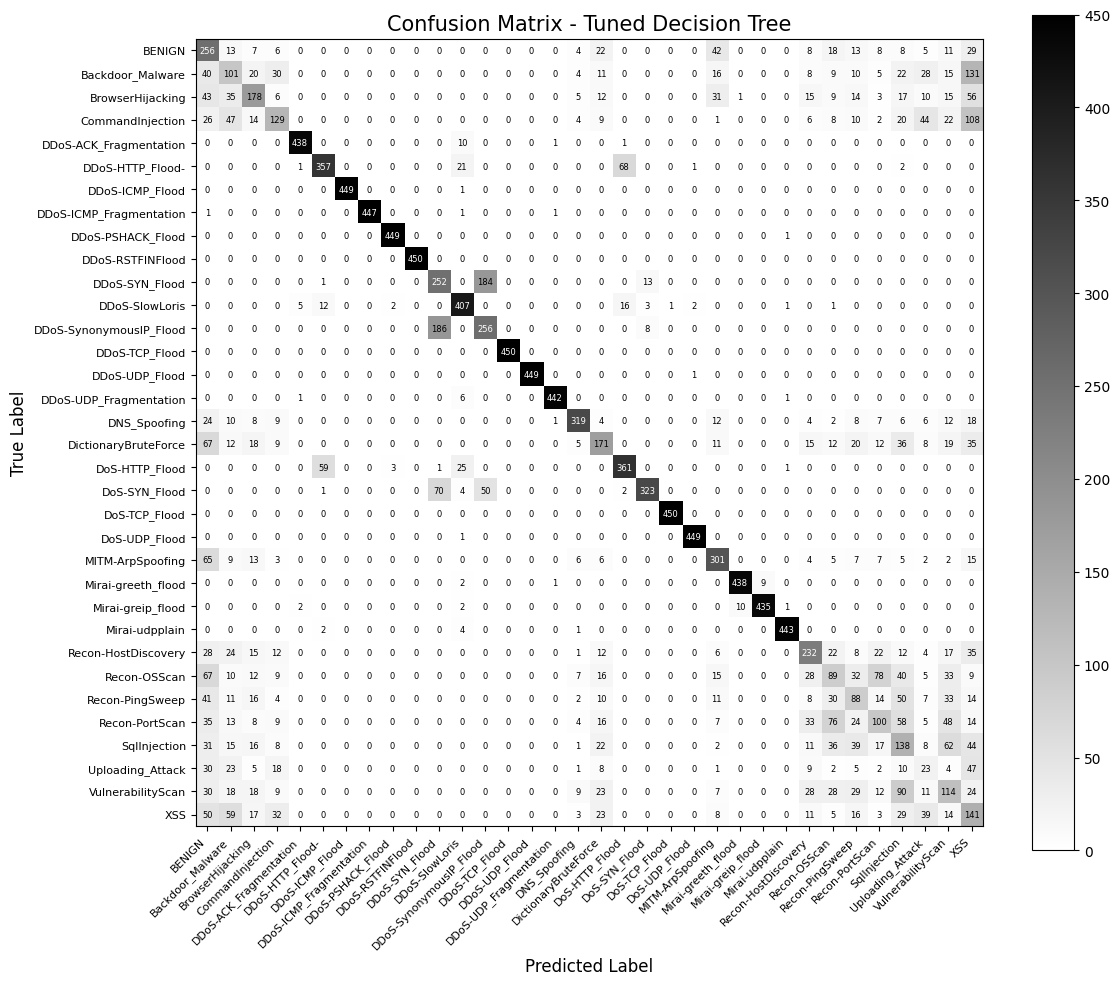

Top 5 most misclassified classes for Decision Tree:
  Class Uploading_Attack: 165 misclassified (87.77% error rate)
  Class Recon-OSScan: 361 misclassified (80.22% error rate)
  Class Recon-PortScan: 350 misclassified (77.78% error rate)
  Class Backdoor_Malware: 349 misclassified (77.56% error rate)
  Class VulnerabilityScan: 336 misclassified (74.67% error rate)

Random Forest Confusion Matrix:


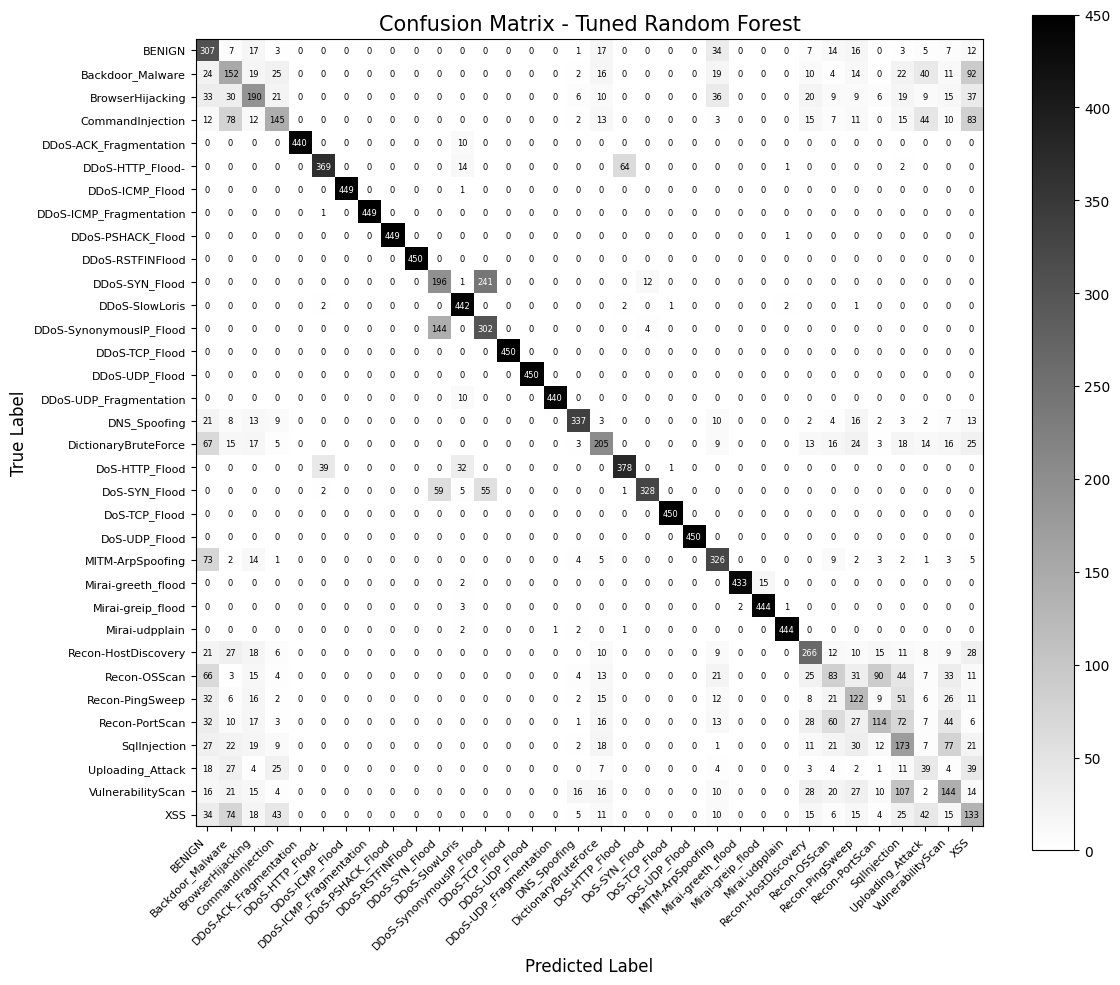

Top 5 most misclassified classes for Random Forest:
  Class Recon-OSScan: 367 misclassified (81.56% error rate)
  Class Uploading_Attack: 149 misclassified (79.26% error rate)
  Class Recon-PortScan: 336 misclassified (74.67% error rate)
  Class XSS: 317 misclassified (70.44% error rate)
  Class VulnerabilityScan: 306 misclassified (68.00% error rate)

XGBoost Confusion Matrix:


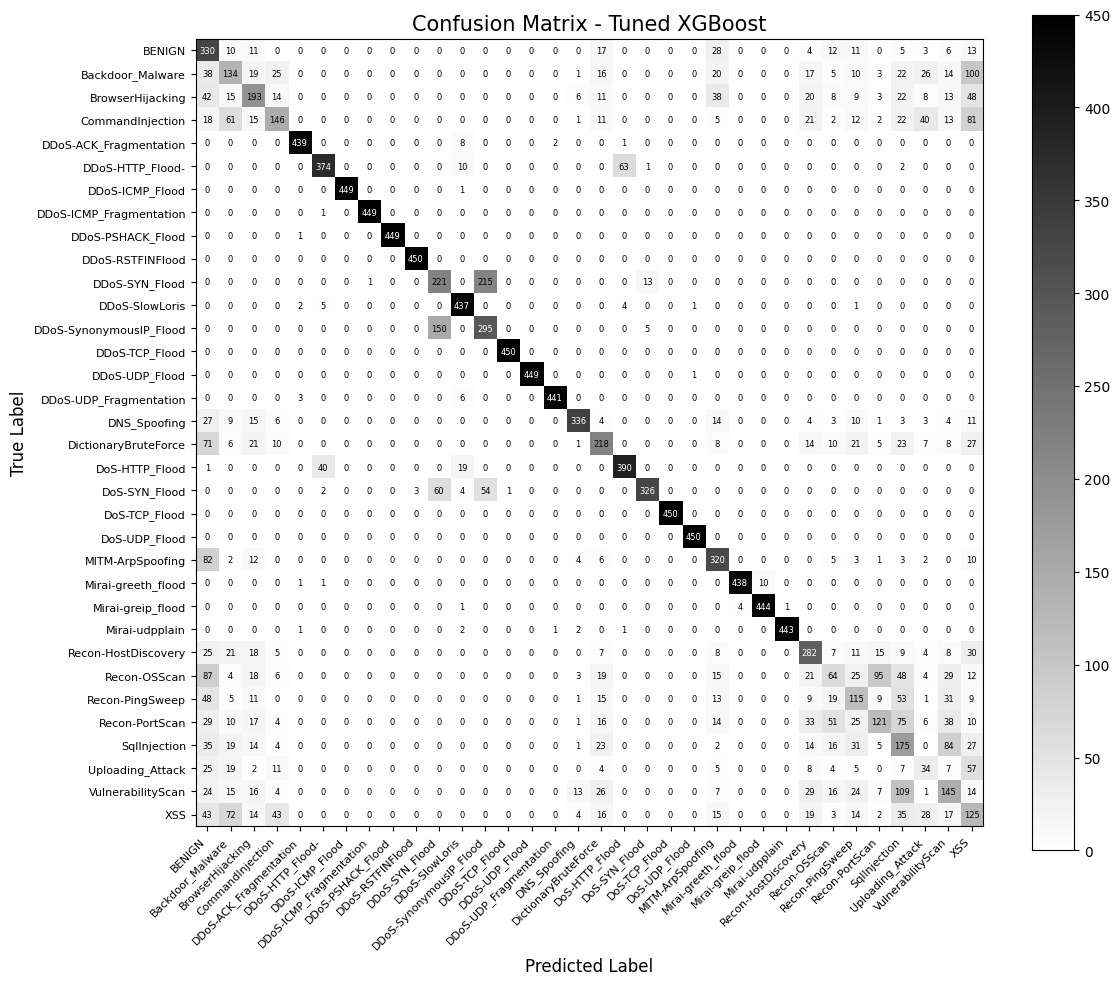

Top 5 most misclassified classes for XGBoost:
  Class Recon-OSScan: 386 misclassified (85.78% error rate)
  Class Uploading_Attack: 154 misclassified (81.91% error rate)
  Class Recon-PortScan: 329 misclassified (73.11% error rate)
  Class XSS: 325 misclassified (72.22% error rate)
  Class Backdoor_Malware: 316 misclassified (70.22% error rate)


In [ ]:
#Logistic Regression
if "Logistic Regression" in tuned_models:
    print("\nLogistic Regression Confusion Matrix:")
    lr_val_pred_tuned = tuned_models["Logistic Regression"]["model"].predict(X_val_processed)
    lr_cm = plot_confusion_matrix(y_val, lr_val_pred_tuned, 
                               "Confusion Matrix - Tuned Logistic Regression")
    plt.tight_layout()
    plt.show()
    
    #Print summary metrics per class
    print("Top 5 most misclassified classes for Logistic Regression:")
    misclassified = []
    for i, cls in enumerate(np.unique(y_val)):
        true_pos = lr_cm[i, i]
        false_neg = np.sum(lr_cm[i, :]) - true_pos
        misclassified.append((cls, false_neg, false_neg / (true_pos + false_neg)))
    
    #Sort by error rate and display top 5
    for cls, count, rate in sorted(misclassified, key=lambda x: x[2], reverse=True)[:5]:
        print(f"  Class {cls}: {count} misclassified ({rate:.2%} error rate)")

# Decision Tree
if "Decision Tree (Tuned)" in tuned_models:
    print("\nDecision Tree Confusion Matrix:")
    dt_val_pred_tuned = tuned_models["Decision Tree (Tuned)"]["model"].predict(X_val_processed)
    dt_cm = plot_confusion_matrix(y_val, dt_val_pred_tuned, 
                               "Confusion Matrix - Tuned Decision Tree")
    plt.tight_layout()
    plt.show()
    
    #Print summary metrics per class
    print("Top 5 most misclassified classes for Decision Tree:")
    misclassified = []
    for i, cls in enumerate(np.unique(y_val)):
        true_pos = dt_cm[i, i]
        false_neg = np.sum(dt_cm[i, :]) - true_pos
        misclassified.append((cls, false_neg, false_neg / (true_pos + false_neg)))
    
    #Sort by error rate and display top 5
    for cls, count, rate in sorted(misclassified, key=lambda x: x[2], reverse=True)[:5]:
        print(f"  Class {cls}: {count} misclassified ({rate:.2%} error rate)")

#Random Forest
if "Random Forest" in tuned_models:
    print("\nRandom Forest Confusion Matrix:")
    rf_val_pred_tuned = tuned_models["Random Forest"]["model"].predict(X_val_processed)
    rf_cm = plot_confusion_matrix(y_val, rf_val_pred_tuned, 
                               "Confusion Matrix - Tuned Random Forest")
    plt.tight_layout()
    plt.show()
    
    #Print summary metrics per class
    print("Top 5 most misclassified classes for Random Forest:")
    misclassified = []
    for i, cls in enumerate(np.unique(y_val)):
        true_pos = rf_cm[i, i]
        false_neg = np.sum(rf_cm[i, :]) - true_pos
        misclassified.append((cls, false_neg, false_neg / (true_pos + false_neg)))
    
    #Sort by error rate and display top 5
    for cls, count, rate in sorted(misclassified, key=lambda x: x[2], reverse=True)[:5]:
        print(f"  Class {cls}: {count} misclassified ({rate:.2%} error rate)")

#XGBoost
if "XGBoost" in tuned_models:
    print("\nXGBoost Confusion Matrix:")
    #XGBoost needs special handling for encoded labels
    xgb_val_pred_tuned_encoded = tuned_models["XGBoost"]["model"].predict(X_val_processed)
    xgb_val_pred_tuned = label_encoder.inverse_transform(xgb_val_pred_tuned_encoded)
    xgb_cm = plot_confusion_matrix(y_val, xgb_val_pred_tuned, 
                                "Confusion Matrix - Tuned XGBoost")
    plt.tight_layout()
    plt.show()
    
    #Print summary metrics per class
    print("Top 5 most misclassified classes for XGBoost:")
    misclassified = []
    for i, cls in enumerate(np.unique(y_val)):
        true_pos = xgb_cm[i, i]
        false_neg = np.sum(xgb_cm[i, :]) - true_pos
        misclassified.append((cls, false_neg, false_neg / (true_pos + false_neg)))
    
    #Sort by error rate and display top 5
    for cls, count, rate in sorted(misclassified, key=lambda x: x[2], reverse=True)[:5]:
        print(f"  Class {cls}: {count} misclassified ({rate:.2%} error rate)")